In [ ]:
import torch

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True,
)
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor()
)

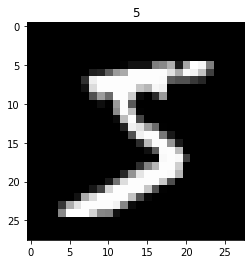

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(train_data.data[0], cmap='gray')
plt.title('%i' % train_data.targets[0])
plt.show()

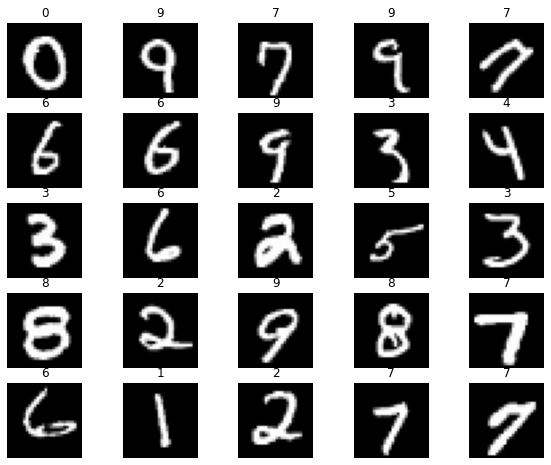

In [ ]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=1),

    'test'  : torch.utils.data.DataLoader(test_data,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=1),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f15484ce790>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f15484ce040>}

In [ ]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        # fully connected layer, output 10 classes
        self.fc = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.flatten(start_dim=1) # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = self.fc(x)
        return output, x    # return x for visualization

In [ ]:
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)


In [ ]:
loss_func = nn.CrossEntropyLoss()
loss_func

CrossEntropyLoss()

In [ ]:
from torch import optim
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.01
    maximize: False
    weight_decay: 0
)

In [ ]:
from torch.autograd import Variable
num_epochs = 10
def train(num_epochs, cnn, loaders):

    cnn.train() # set to train mode

    # Train the model
    total_step = len(loaders['train'])

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):

            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)[0]
            loss = loss_func(output, b_y)

            # clear gradients for this training step
            optimizer.zero_grad() ## very very important

            # backpropagation, compute gradients
            loss.backward()
            # apply gradients
            optimizer.step()

            if (i+1) % 100 == 0:
                print (f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{total_step}], Loss: {loss.item():.4f}')

In [ ]:
train(num_epochs, cnn, loaders)

Epoch [1/10], Step [100/600], Loss: 0.1441
Epoch [1/10], Step [200/600], Loss: 0.1936
Epoch [1/10], Step [300/600], Loss: 0.1248
Epoch [1/10], Step [400/600], Loss: 0.0484
Epoch [1/10], Step [500/600], Loss: 0.0462
Epoch [1/10], Step [600/600], Loss: 0.0802
Epoch [2/10], Step [100/600], Loss: 0.0508
Epoch [2/10], Step [200/600], Loss: 0.0792
Epoch [2/10], Step [300/600], Loss: 0.0694
Epoch [2/10], Step [400/600], Loss: 0.0680
Epoch [2/10], Step [500/600], Loss: 0.0121
Epoch [2/10], Step [600/600], Loss: 0.1181
Epoch [3/10], Step [100/600], Loss: 0.0235
Epoch [3/10], Step [200/600], Loss: 0.1061
Epoch [3/10], Step [300/600], Loss: 0.0613
Epoch [3/10], Step [400/600], Loss: 0.0348
Epoch [3/10], Step [500/600], Loss: 0.0881
Epoch [3/10], Step [600/600], Loss: 0.0188
Epoch [4/10], Step [100/600], Loss: 0.0039
Epoch [4/10], Step [200/600], Loss: 0.0311
Epoch [4/10], Step [300/600], Loss: 0.0144
Epoch [4/10], Step [400/600], Loss: 0.0085
Epoch [4/10], Step [500/600], Loss: 0.0293
Epoch [4/10

In [ ]:
def test():
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            pass
    print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)

In [ ]:
test()

Test Accuracy of the model on the 10000 test images: 0.99


In [ ]:
# print 10 predictions from test data
sample = next(iter(loaders['test']))
imgs, lbls = sample
actual_number = lbls[:10].numpy()
test_output, last_layer = cnn(imgs[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(f'Prediction number: {pred_y}')
print(f'Actual number: {actual_number}')

Prediction number: [7 7 7 2 1 1 6 9 0 2]
Actual number: [7 7 7 2 1 1 6 9 0 2]


In [ ]:
torch.save(cnn.state_dict(), "model.pth")

In [ ]:
state_dict = torch.load("model.pth")
cnn.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import utils

def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1):
    n,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

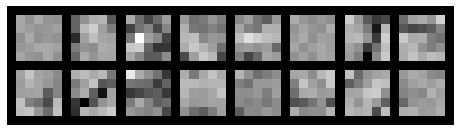

In [ ]:
fil = cnn.conv1[0].weight.data.clone()
visTensor(fil, ch=0, allkernels=False)

plt.axis('off')
plt.ioff()
plt.show()

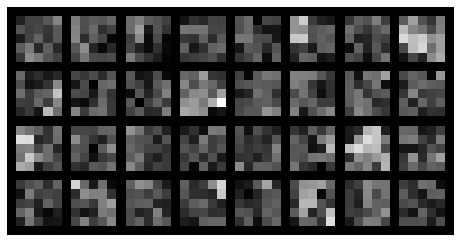

In [ ]:
fil = cnn.conv2[0].weight.data.clone()
visTensor(fil, ch=0, allkernels=False)

plt.axis('off')
plt.ioff()
plt.show()

In [ ]:
import numpy as np
model_parameters = filter(lambda p: p.requires_grad, cnn.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

In [ ]:
params

28938